# Metadata analysis

In [103]:
import pandas as pd
import os
import numpy as np
import sklearn.mixture as mixture
from matplotlib.pyplot import cm
import matplotlib as mpl
import matplotlib.pyplot as plt

In [194]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
%matplotlib inline

## Functions

In [182]:
def map_ads(df, title, reference=None, output_file='heatmap'):

    if reference is None:
        reference = df

    # Init numpy array
    #global_max_x = reference['max_x'].max()
    global_max_x = 5000 #manual override!
    global_max_y = 6500 #manual override
    #global_max_y = reference['max_y'].max()
    heatmap = np.zeros([global_max_y, global_max_x], dtype=np.float32)

    # Count the number of advertisements at each pixel
    for i, row in df.iterrows():
        heatmap[int(row['min_y'])-1:int(row['max_y']),
            int(row['min_x'])-1:int(row['max_x'])] += 1

    # Normalize to values between 0 - 1
    heatmap[:,:] /= np.amax(heatmap)
    
    #map[:,:] /= reference.shape[0]

    # Plot and save heatmap image
    plt.imshow(heatmap, cmap='jet')
    #plt.clim(0, 1)
    plt.colorbar()
    plt.title(title)
    plt.savefig(os.path.join(figures_path, title + '_' + output_file + '.png', bbox_inches='tight', dpi=300))
    plt.show()
    plt.clf()
    
def plot_clusters(df, side):
    
    fig = plt.figure(figsize=(20,20), dpi=80)
    
    ax = fig.add_subplot(111, projection='3d')

    colors=cm.rainbow(np.linspace(0,1,7))

  
    for i in range(1, trouw_subset['classes'].nunique()):
        ax.scatter(df[df['classes'] == i]['w'], df[df['classes'] == i]['rel_page'], df[df['classes'] == i]['h'], alpha=0.7, depthshade=True,cmap='tab10')


    ax.view_init(None, None)
    ax.set_xlabel('Width in pixels', fontsize=20, labelpad=10)
    ax.set_ylabel('Relative position (0 = front, 1 = back)', fontsize=20, labelpad=10)
    ax.set_zlabel('Height in pixels', fontsize=20, labelpad=10)
#     plt.yticks(fontsize=14, alpha=.7)
#     plt.xticks(fontsize=14, alpha=.7)
#     plt.zticks(fontsize=14, alpha=.7)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.zaxis.set_tick_params(labelsize=15)
    


    ax.set_zlim3d(0, 6500)  
    ax.set_xlim3d(0, 5500)  
    # plt.xlabel(r'Width')
    # plt.ylabel(r'Page Number (normalized)')
    # plt.zslabel(r'Height')
    #plt.title(f'Clusters of advertisements on {side} pages')
    plt.tight_layout()
    plt.savefig(f'clusters_{side}.jpg')


# Preparing Metadata

In [22]:
data_path = '../../../../Dropbox/datasets/newspapers_clean/'
figures_path = '../ms/figures/'
processed_data_path = '../data/'

In [23]:
meta_data = pd.read_csv(os.path.join(processed_data_path, 'full_metadata.csv'))
meta_data['date'] = pd.to_datetime(meta_data['date'])

# Analyze metadata

In [192]:
def plot_ad_curve(meta, title, freq):
    meta['date'] = pd.to_datetime(meta['date'])
    meta = meta[meta['newspaper_name'] == title]
    meta['years'] = pd.DatetimeIndex(meta['date']).year
    meta = meta[meta['years'] >= 1945]
    start_year = meta['years'].min()
    end_year = meta['years'].max()
    df = meta.groupby(pd.Grouper(key='date', freq=freq))['page'].count()
    #df = df[df.values != 0] # re
    
    data = df.values
    doublediff = np.diff(np.sign(np.diff(data)))
    peak_locations = np.where(doublediff == -2)[0] + 1

    doublediff2 = np.diff(np.sign(np.diff(-1*data)))
    trough_locations = np.where(doublediff2 == -2)[0] + 1
    
    plt.figure(figsize=(16, 10), dpi=80)
    plt.plot(df.index, df.values, color='tab:red', lw=3)
    plt.scatter(df.index[peak_locations], df.values[peak_locations], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Peaks')
    plt.scatter(df.index[trough_locations], df.values[trough_locations], marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Troughs')

    for t, p in zip(trough_locations, peak_locations):
        plt.text(df.index[p], df.values[p]+1000, int(str(df.index[p])[:4])+1, fontsize=14, horizontalalignment='center', color='darkgreen')
        plt.text(df.index[t], df.values[t]-1500, int(str(df.index[t])[:4])+1, fontsize=14, horizontalalignment='center', color='darkred')

#     plt.yticks(fontsize=12, alpha=.7)
#     plt.xticks(fontsize=12, alpha=.7)

    title = title.capitalize()
    plt.title(f'Yearly number of ads in {title} ({start_year} - {end_year})', fontsize=22)
    plt.grid(axis='both', alpha=.3)

    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)  
    plt.savefig(os.path.join(figures_path, f'{title}_ad_curve.jpg'))
    plt.show()

    

In [25]:
meta_data['years'] = pd.DatetimeIndex(meta_data['date']).year
meta_data = meta_data[meta_data['years'] <= 1990] #filter everything before 1991

In [32]:
meta_data['newspaper_name'] = meta_data['newspaper_name'].str.lower().str.replace(' ', '_')

### Show totals all newspapers

In [33]:
start = meta_data.groupby(['newspaper_name'])['years'].min()
end = meta_data.groupby(['newspaper_name'])['years'].max()
totals = meta_data.groupby(['newspaper_name'])['page'].count()

corpus_df = pd.concat([start, end, totals], axis=1)
corpus_df.columns = ['start_year', 'end_year', 'total_ads']
corpus_df

start_year  end_year  total_ads
newspaper_name                                               
algemeen_handelsblad                1906      1970     988610
detijd                              1890      1958     536180
het_volk                            1919      1945     191026
nieuwe_rotterdamsche_courant        1909      1929     467448
nn                                  1890      1990    2046793
nrc_handelsblad                     1970      1990     447442
parool                              1945      1990    1575072
steenwijker_courant                 1869      1945     132132
telegraaf                           1893      1990    3618431
trouw                               1946      1990    1114229
vaderland                           1919      1945     312082
vk                                  1940      1990    1188205
vv                                  1945      1990    1542048

In [34]:
selected_papers = ['algemeen_handelsblad', 'detijd', 'het_volk',
                  'nieuwe_rotterdamsche_courant', 'nrc', 'parool',
                  'telegraaf', 'trouw', 'vaderland', 'vk', 'vv']

meta_data = meta_data[meta_data['newspaper_name'].isin(selected_papers)]

<AxesSubplot:xlabel='date'>

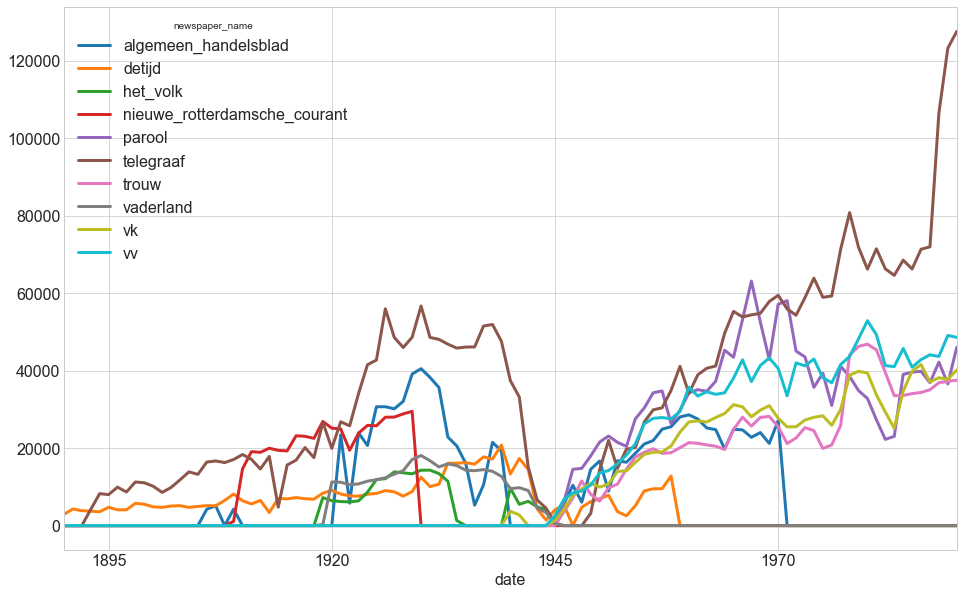

In [35]:
plot = meta_data.groupby(['newspaper_name', 'date'])['page'].count()
plot_df = plot.unstack('newspaper_name').loc[:, ]
plot_df.reset_index().groupby(pd.Grouper(key='date', freq='Y')).sum().plot(figsize=(16,10), lw=3)

In [36]:
trouw_total = meta_data[meta_data['newspaper_name'] == 'trouw'].shape[0]
vk_total = meta_data[meta_data['newspaper_name'] == 'vk'].shape[0]

In [37]:
print(f'Total number of ads in Trouw: {trouw_total}')
print(f'Total number of ads in Volkskrant: {vk_total}')

Total number of ads in Trouw: 1114229
Total number of ads in Volkskrant: 1188205


## plot single newspaper

<ipython-input-192-d7294552716f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['years'] = pd.DatetimeIndex(meta['date']).year


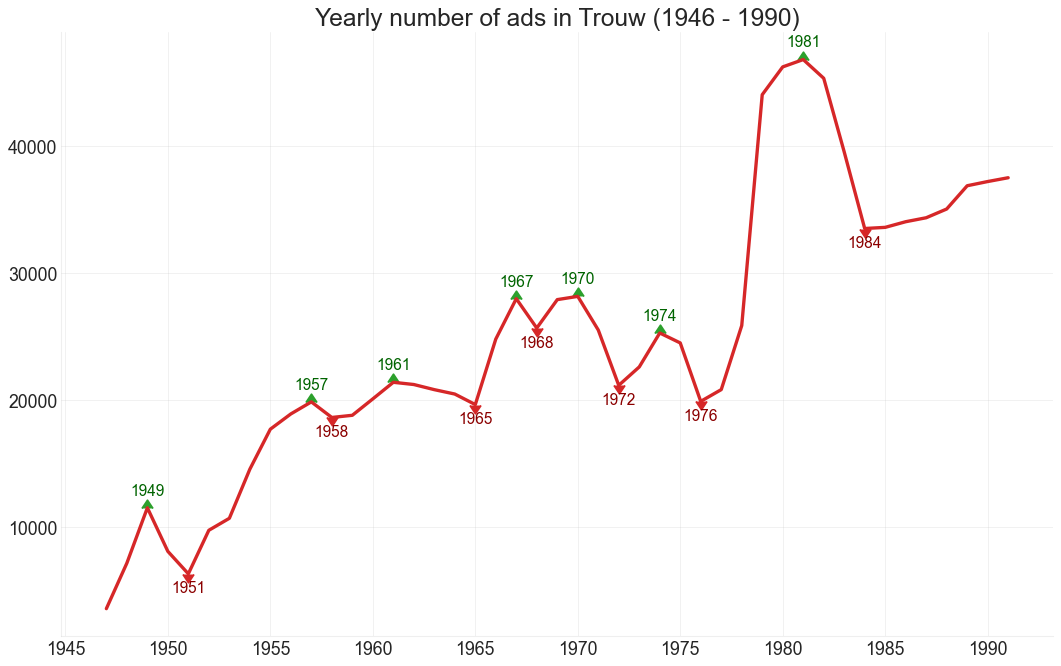

In [193]:
plot_ad_curve(meta_data, 'trouw', 'Y')

### Study Size

In [41]:
meta_data['size'] = meta_data['size'].astype(int)
meta_data['log_size'] = np.log10(meta_data['size'])

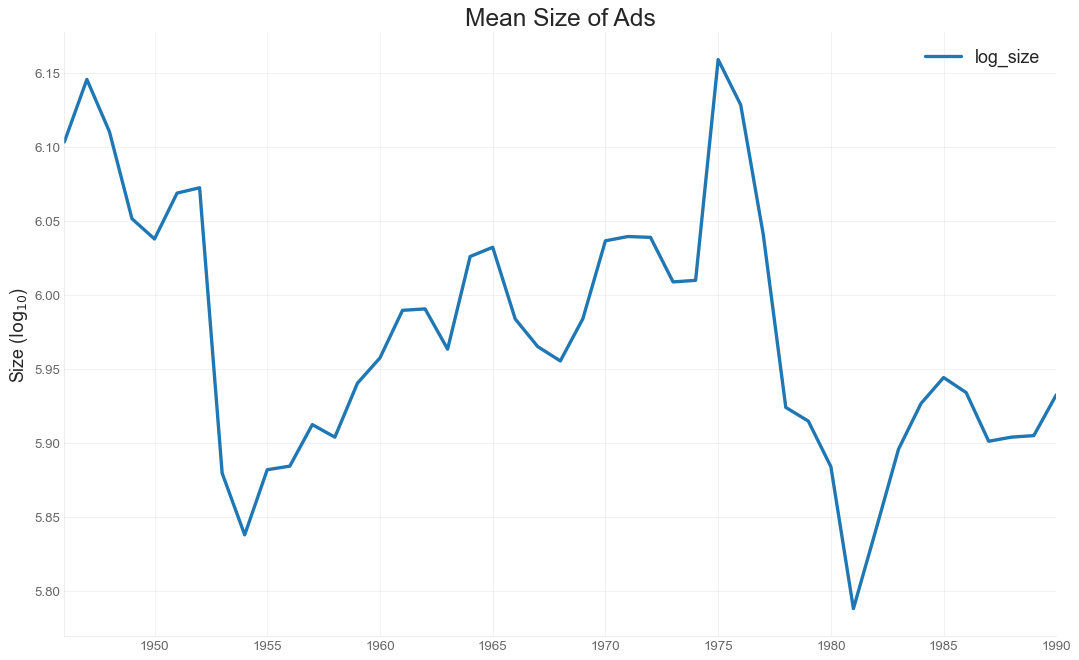

In [189]:
plt.figure(figsize=(16, 10), dpi=80)

meta_data['years'] = pd.DatetimeIndex(meta_data['date']).year
meta_data = meta_data[meta_data['years'] >= 1945]

#meta_data[meta_data['newspaper_name'] == 'vk'].groupby(pd.Grouper(key='date', freq='Y')).mean()['log_size'].plot(label='vk', color='tab:red', lw=3)
meta_data[meta_data['newspaper_name'] == 'trouw'].groupby(pd.Grouper(key='date', freq='Y'))['log_size'].mean().plot(color='tab:blue', lw=3)
plt.legend()


plt.xticks(fontsize=12, alpha=.7)
plt.yticks(fontsize=12, alpha=.7)

#plt.ylim(0, 6.5)
plt.title('Mean Size of Ads', fontsize=22)
plt.grid(axis='both', alpha=.3)
plt.ylabel(r'Size ($\log_{10}$)')
plt.xlabel("")

plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)  
plt.savefig(os.path.join(figures_path, 'mean_size.jpg'))
plt.show()

### Make heatmap

In [147]:
trouw_meta = meta_data[meta_data['newspaper_name'] == 'trouw']

In [148]:
#calculate relative page position
max_pages = trouw_meta.groupby(pd.Grouper(key='date', freq='D'))['page'].max()
trouw_meta = pd.merge(trouw_meta, max_pages, on='date')
trouw_meta.rename(columns={'page_x': 'page', 'page_y': 'total_pages'}, inplace=True)
trouw_meta['rel_page'] = trouw_meta['page'] / trouw_meta['total_pages']

In [149]:
#trouw_meta['normalized_perc_digits'] = (trouw_meta['perc_digits']-trouw_meta['perc_digits'].mean())/trouw_meta['perc_digits'].std()
#trouw_meta['normalized_character_proportion'] = (trouw_meta['character_proportion']-trouw_meta['character_proportion'].mean())/trouw_meta['character_proportion'].std()

trouw_meta['normalized_page'] = (trouw_meta['rel_page']-trouw_meta['rel_page'].mean())/trouw_meta['rel_page'].std()

In [150]:
# make the even odd variable
trouw_meta['even_odd'] = np.where(trouw_meta['page'] % 2 == 0, 'even', 'odd')

side is odd
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True


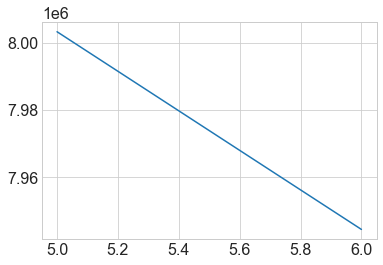

side is even
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


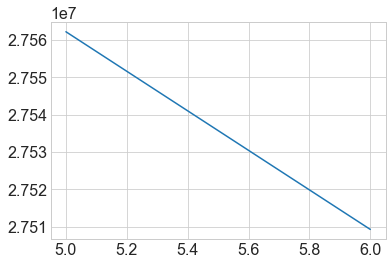

<Figure size 432x288 with 0 Axes>

In [155]:
#figure out optimal number of components
for side in ['odd', 'even']:
    print(f'side is {side}')
    data = trouw_meta[trouw_meta['even_odd'] == side][['w', 'h', 'rel_page']]

    
    n_components = np.arange(3, 12)
    models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0, verbose=1, max_iter=1500).fit(data)
              for n in n_components]
    
    plt.plot(n_components, [m.aic(data) for m in models], label='AIC')
    plt.show()
    plt.clf()

Optimum for even is 8 and for odd is 7

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


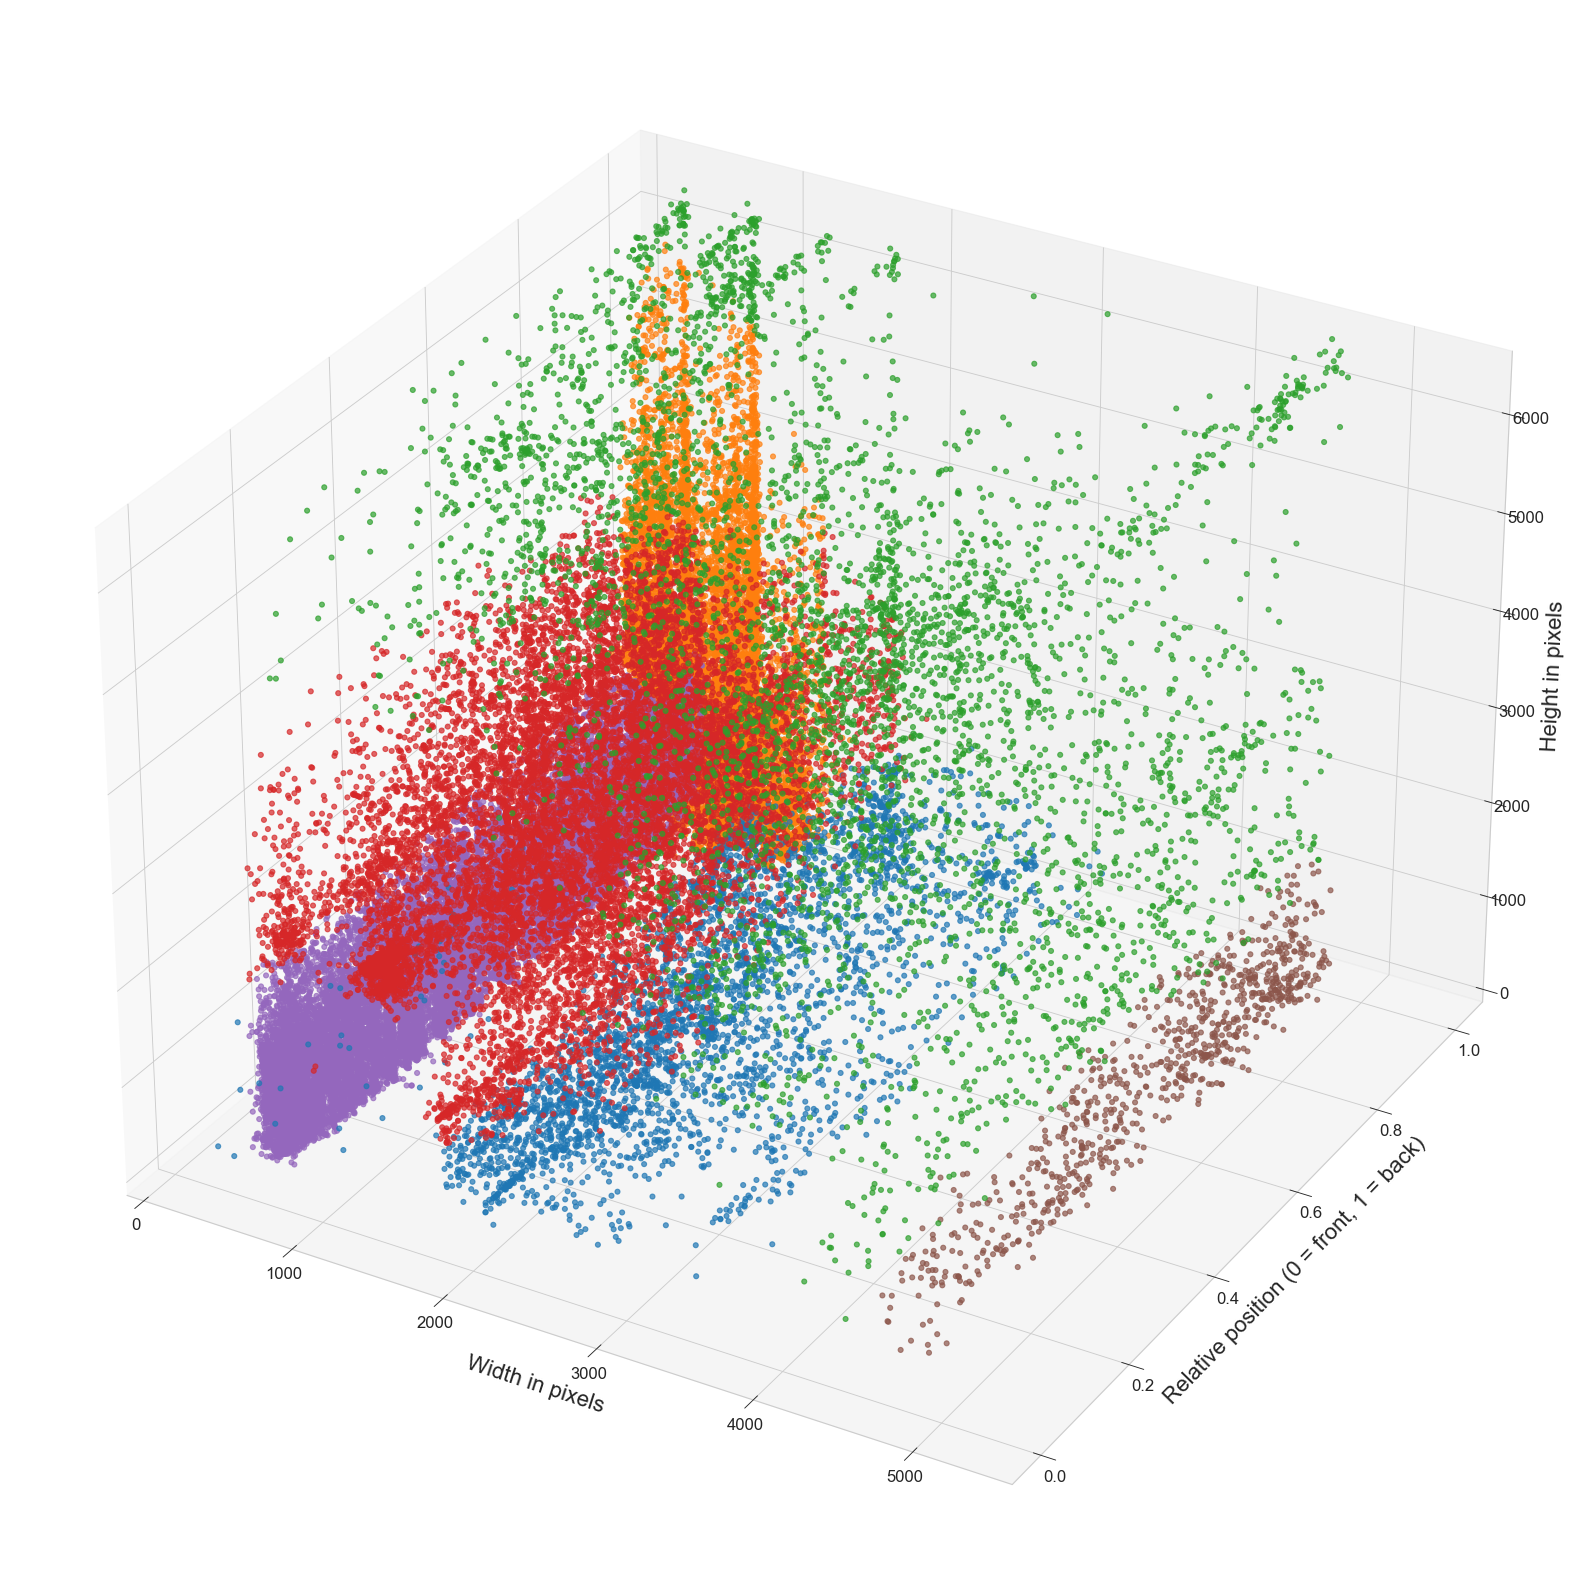

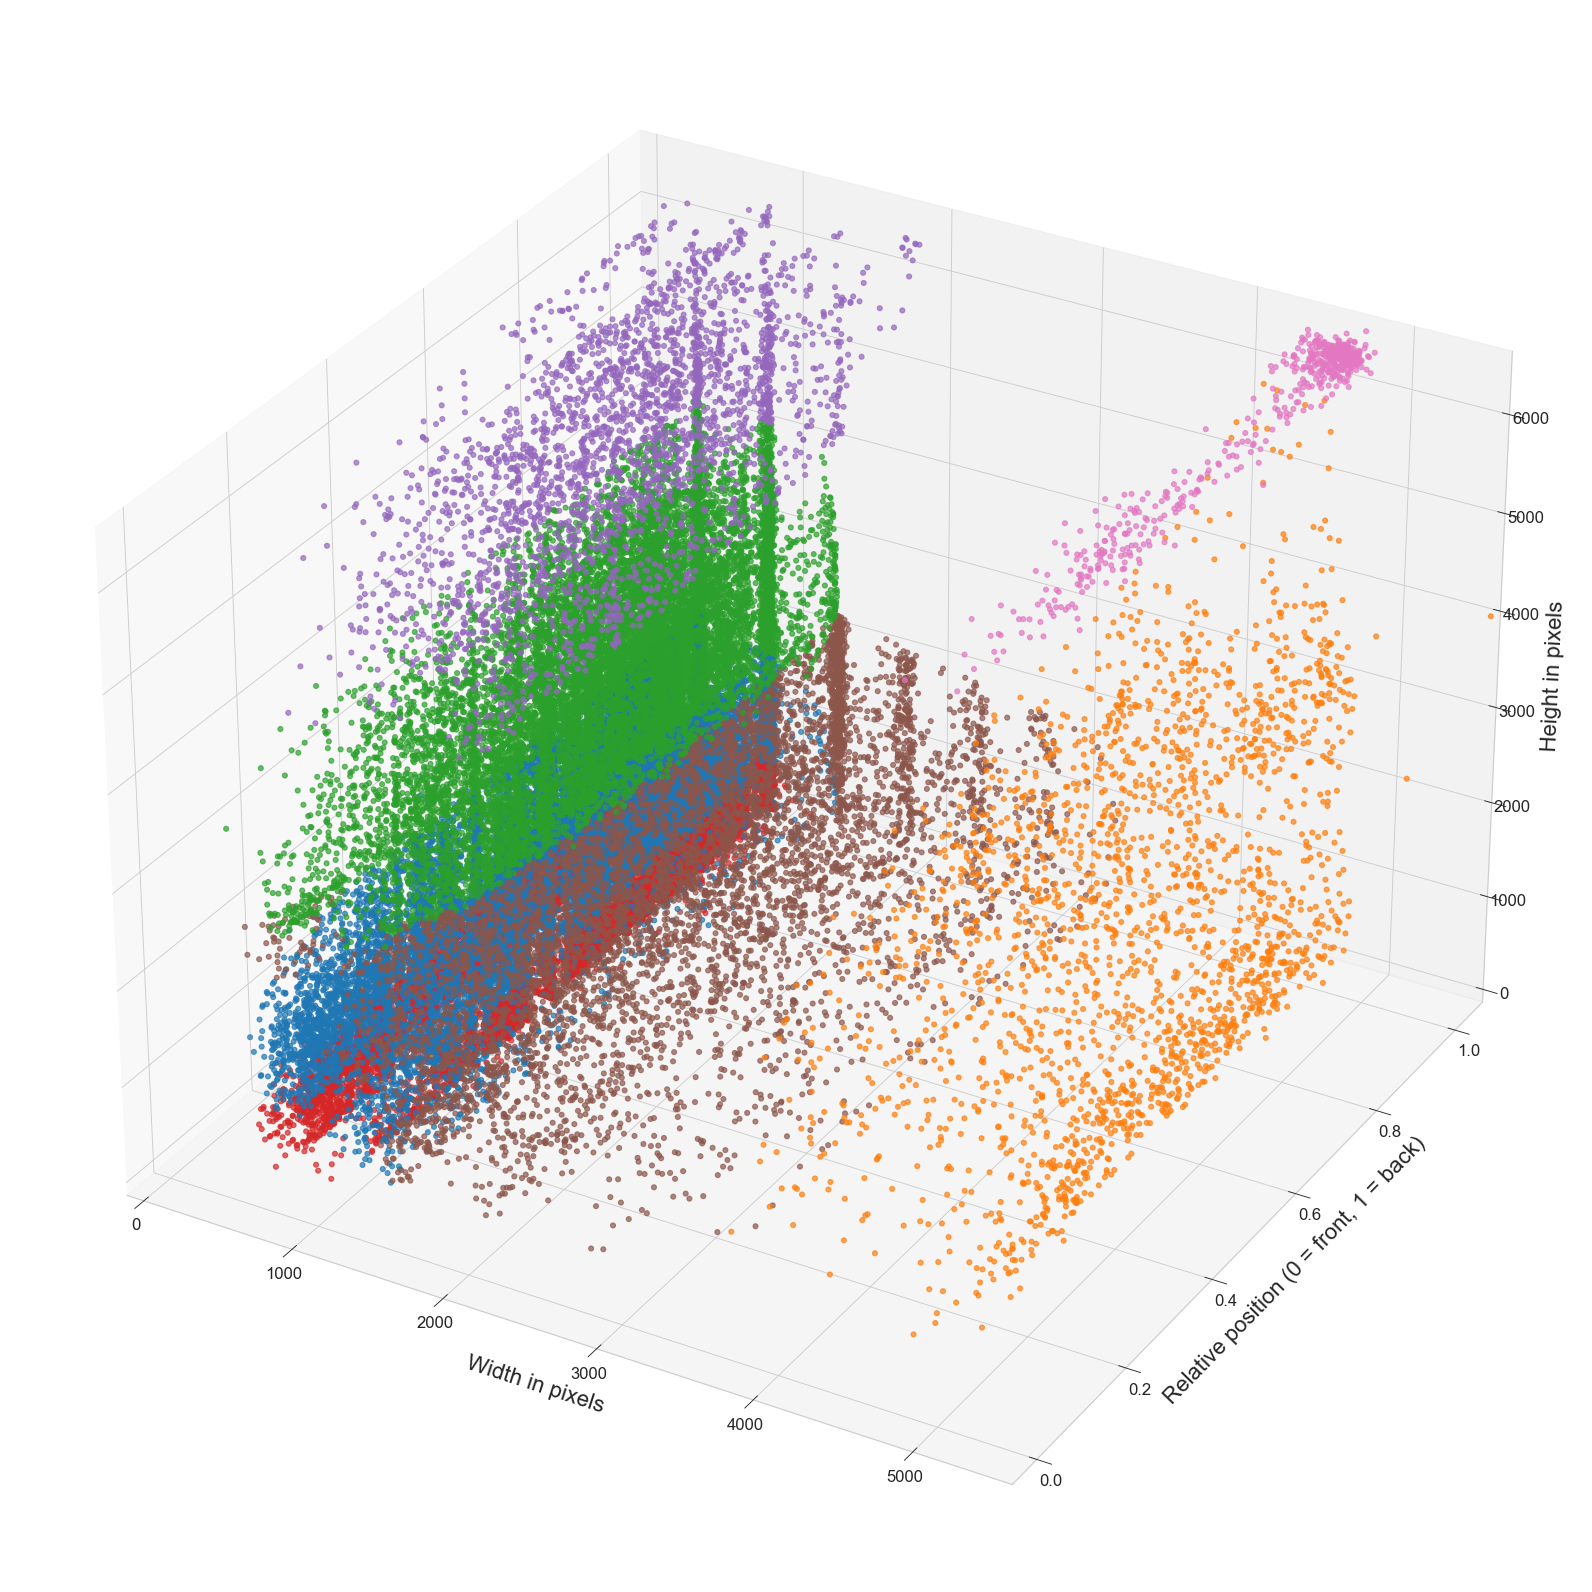

In [185]:
for side in ['odd', 'even']:
    data = trouw_meta[trouw_meta['even_odd'] == side][['w', 'h', 'rel_page']]
    if side == 'odd':
        gmm = mixture.GaussianMixture(n_components=7, covariance_type='full', verbose=1, max_iter=1500).fit(data)
    else:
        gmm = mixture.GaussianMixture(n_components=8, covariance_type='full', verbose=1, max_iter=1500).fit(data)
       
  
    trouw_subset = trouw_meta[trouw_meta['even_odd'] == side].sample(75000)
    trouw_subset['classes'] = trouw_subset.apply(lambda x: gmm.predict([[x['w'], x['h'], x['rel_page']]])[0], axis=1)
    plot_clusters(trouw_subset, side)

1
2
3
4
5
6


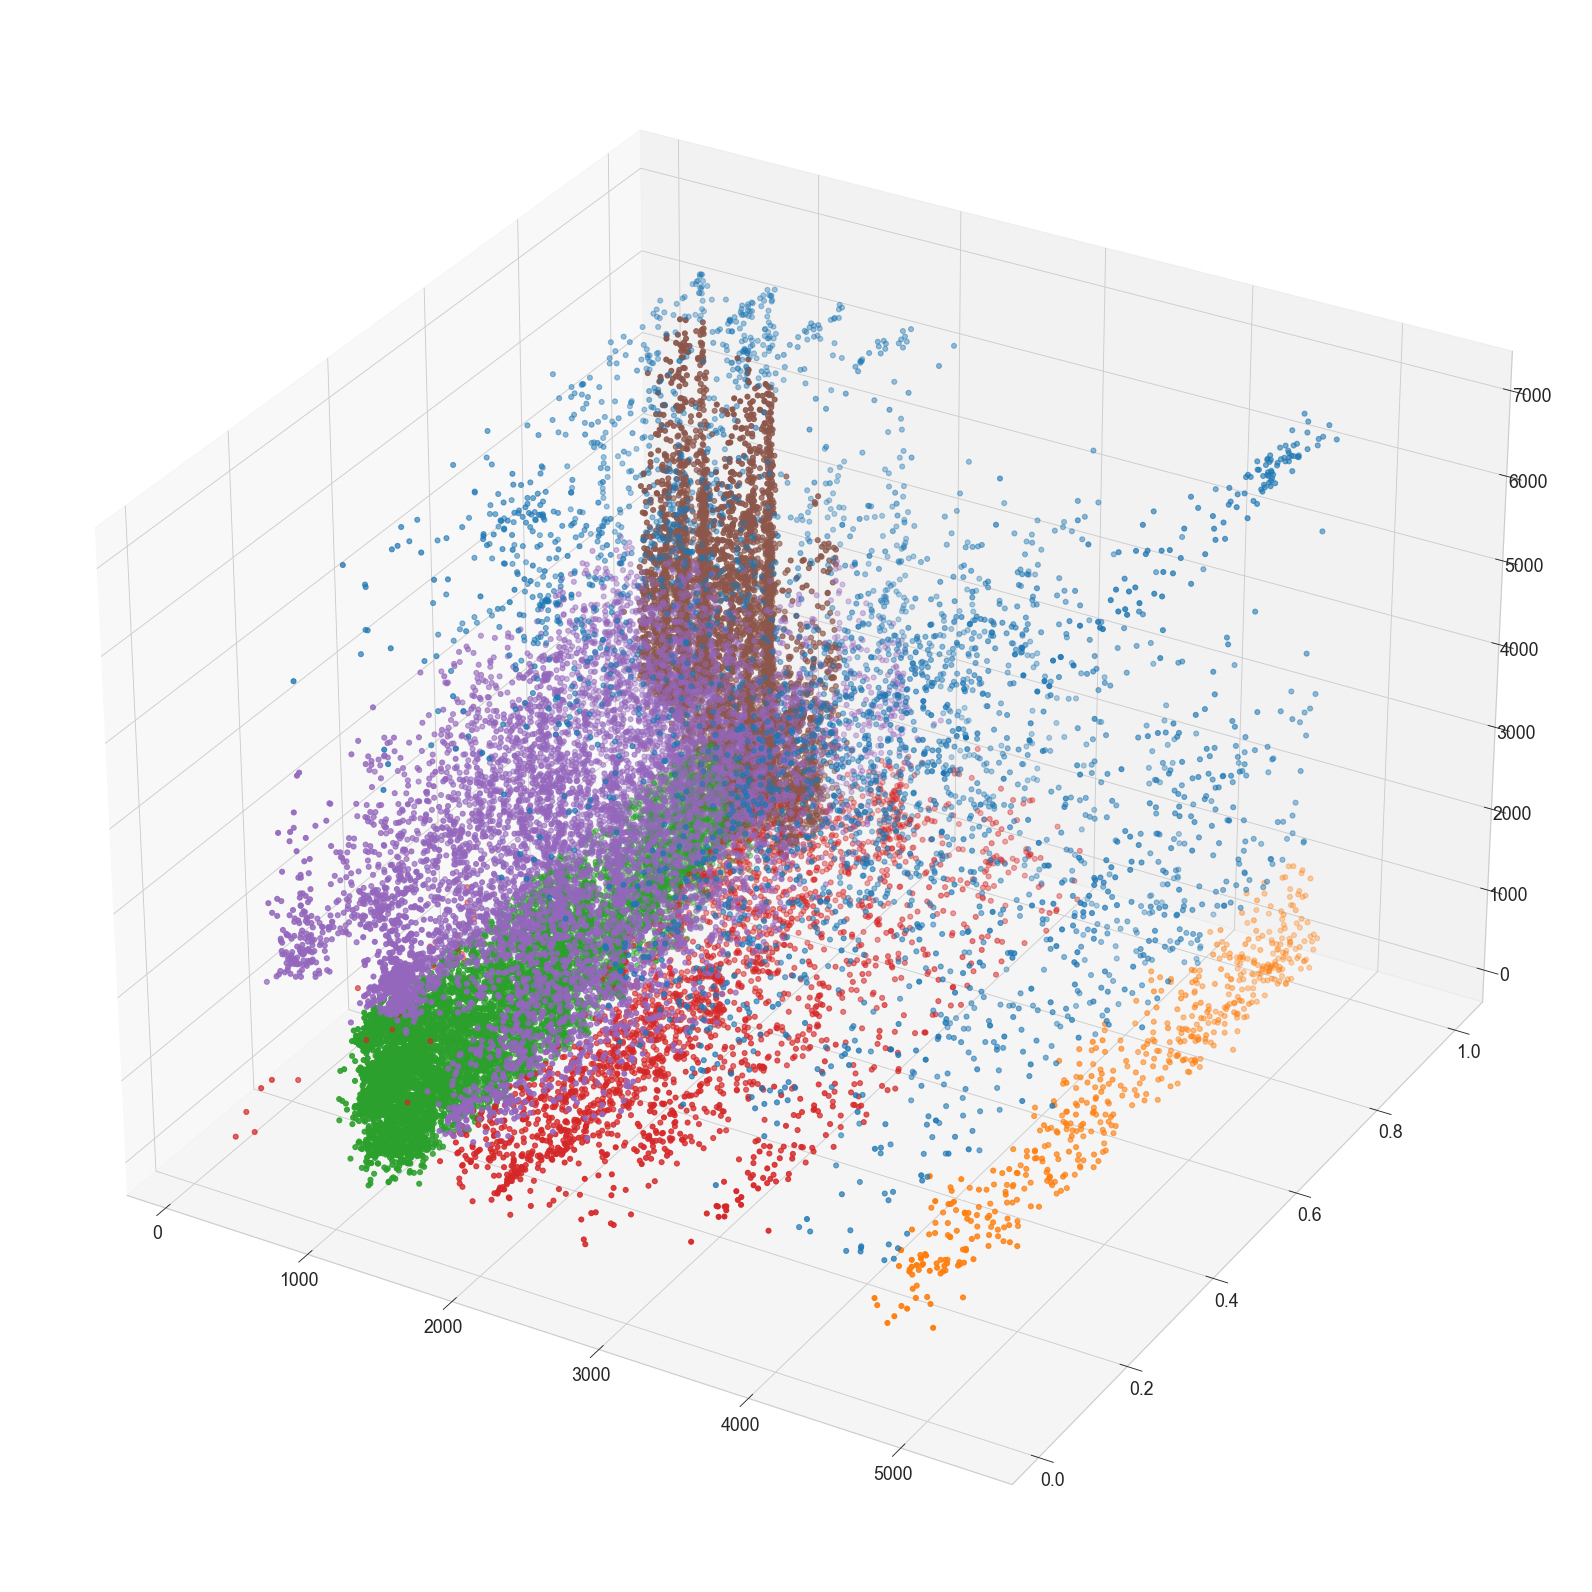

In [123]:
fig = plt.figure(figsize=(20,20), dpi=80)
from matplotlib.pyplot import cm
ax = fig.add_subplot(111, projection='3d')

colors=cm.rainbow(np.linspace(0,1,7))

for i in range(1, trouw_subset['classes'].nunique()):
    print(i)
    ax.scatter(trouw_subset[trouw_subset['classes'] == i]['w'], trouw_subset[trouw_subset['classes'] == i]['rel_page'], trouw_subset[trouw_subset['classes'] == i]['h'], depthshade=True,cmap='tab10')

plt.tight_layout()

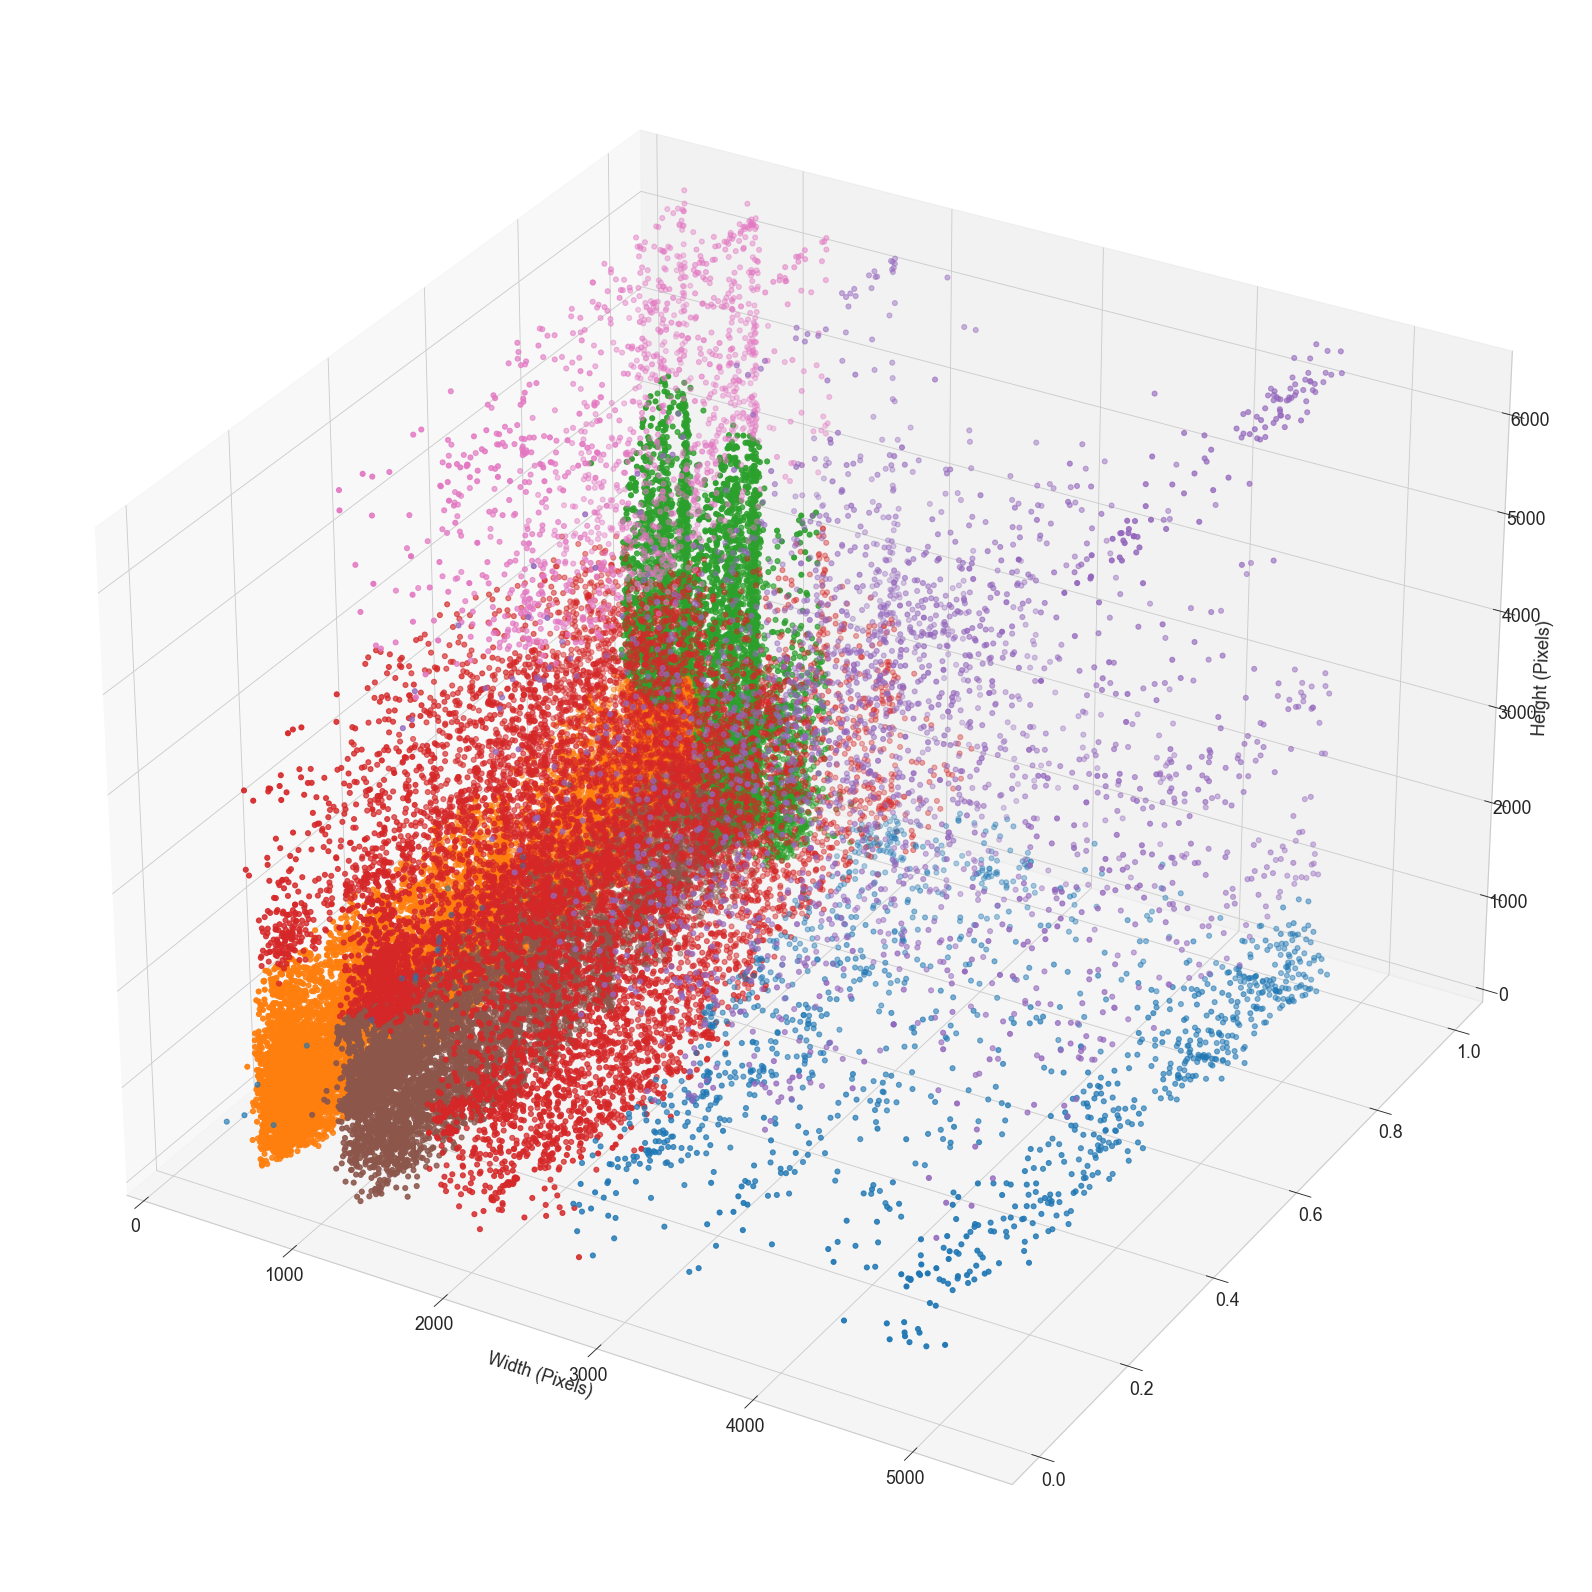

In [100]:
fig = plt.figure(figsize=(20,20), dpi=80)
from matplotlib.pyplot import cm
ax = fig.add_subplot(111, projection='3d')

colors=cm.rainbow(np.linspace(0,1,7))

for i, (mean, cov, color) in enumerate(zip(gmm.means_, gmm.covariances_, colors)):
    
    ax.scatter(trouw_subset[trouw_subset['classes'] == i]['w'], trouw_subset[trouw_subset['classes'] == i]['rel_page'], trouw_subset[trouw_subset['classes'] == i]['h'], depthshade=True,cmap='tab10')


ax.view_init(None, None)
ax.set_xlabel('Width (Pixels)')

ax.set_zlabel('Height (Pixels)')

ax.set_zlim3d(0, 6500)  
ax.set_xlim3d(0, 5500)  
# plt.xlabel(r'Width')
# plt.ylabel(r'Page Number (normalized)')
# plt.zslabel(r'Height')
plt.tight_layout()
plt.savefig('even_sizes.jpg')


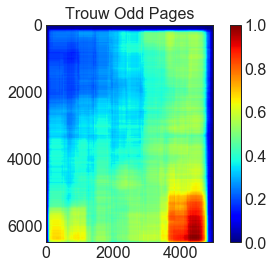

<Figure size 432x288 with 0 Axes>

In [439]:
map_ads(trouw_meta.loc[(trouw_meta['even_odd'] == 'odd')].sample(2000), 'Trouw Odd Pages')

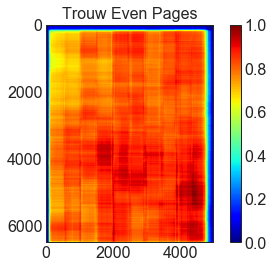

<Figure size 432x288 with 0 Axes>

In [440]:
map_ads(trouw_meta.loc[(trouw_meta['even_odd'] == 'even')].sample(2000), 'Trouw Even Pages')

# classifieds

In [ ]:
meta_data[(meta_data['h'] > 5000) & (meta_data['w'] < 1000)]